# Reinforcement Learning Final Project 

Welcome to your Reinforcement Learning project focused on developing an RL agent capable of playing chess at a strategic level. Chess has long been considered a benchmark for measuring AI capabilities, and this project aims to leverage the power of RL to create an intelligent agent that can make optimal decisions in complex chess positions. By combining the principles of reinforcement learning with the rich strategic domain of chess, you will explore new approaches to create the most effective chess player.

## Project Objectives:

* Train an RL agent to play chess: The primary objective of this project is to develop an RL agent that can play chess at a high level of proficiency. The agent should be capable of evaluating chess positions and making strategic decisions.

* Optimize decision-making using RL algorithms: Explore different RL algorithms, as seen in class, to train the agent. Compare and analise their effectiveness in learning and decision-making capabilities in the context of chess.

* Use a challenging chess environment: Use a comprehensive environment for the agent to interact with, representing the rules and dynamics of chess. This environment will provide a realistic and challenging setting for the agent's training and evaluation.

* Evaluate and benchmark performance: Assess the performance of the RL agent against different benchmarks from existing chess engines. You will compare your agent's performance to established chess engines to measure progress and identify areas for improvement.


### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.

* Enhance interpretability and analysis: Develop methods to analise the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.

## Let's Play Chess! 

As you know [Chess](https://en.wikipedia.org/wiki/Chess) is a board game for two players, called White and Black, each controlling an army of chess pieces in their color, with the objective to checkmate the opponent's king.

Chess is an abstract strategy game that involves no hidden information and no use of dice or cards. It is played on a chessboard with 64 squares arranged in an eight-by-eight grid. At the start, each player controls sixteen pieces: one king, one queen, two rooks, two bishops, two knights, and eight pawns. White moves first, followed by Black. Checkmating the opponent's king involves putting the king under immediate attack (in "check") whereby there is no way for it to escape.


![](Images/CHESS_MOVES.PNG)

* The king moves one square in any direction. There is also a special move called castling that involves moving the king and a rook. The king is the most valuable piece — attacks on the king must be immediately countered, and if this is impossible, the game is immediately lost.
* A rook can move any number of squares along a rank or file, but cannot leap over other pieces. Along with the king, a rook is involved during the king's castling move.
* A bishop can move any number of squares diagonally, but cannot leap over other pieces.
* A queen combines the power of a rook and bishop and can move any number of squares along a rank, file, or diagonal, but cannot leap over other pieces.
* A knight moves to any of the closest squares that are not on the same rank, file, or diagonal. (Thus the move forms an "L"-shape: two squares vertically and one square horizontally, or two squares horizontally and one square vertically.) The knight is the only piece that can leap over other pieces.
* A pawn can move forward to the unoccupied square immediately in front of it on the same file, or on its first move it can advance two squares along the same file, provided both squares are unoccupied (black dots in the diagram). A pawn can capture an opponent's piece on a square diagonally in front of it by moving to that square (black crosses). It cannot capture a piece while advancing along the same file. A pawn has two special moves: the en passant capture and promotion.

## The [Environment](https://github.com/iamlucaswolf/gym-chess)

The environment gym-chess provides OpenAI Gym environments for the game of Chess. It comes with an implementation of the board and move encoding used in AlphaZero. 

Please install it using the command: 

`pip install gym-chess`

In [1]:
#!pip install gym-chess

In [1]:
import chess
import gym
import gym_chess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
import random

### A Two player's game

As you know chess is played by two players, as such the gym-chess environment gives you access to both players actions in a sequential matter.

In [2]:
def WHITE_PLAYER_POLICY(env, state):
    legal_actions = env.legal_actions
    action = np.random.choice(legal_actions)
    #action = env.encode(chess.Move.from_uci(np.random.choice(legal_actions)))

    return action


def BLACK_PLAYER_POLICY(env, state):
    legal_actions = env.legal_actions
    action = np.random.choice(legal_actions)
    #action = env.encode(chess.Move.from_uci(np.random.choice(legal_actions)))

    return action

In [3]:
env = gym.make(
    "ChessAlphaZero-v0"
)  # We will use Alpha Zero's numenclature for the actions encodings

state = env.reset()
done = False
counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game

while not done:
    if (
        counter % 2 == 0
    ):  # If the step number is pair, this means that it is the WHITE player's turn
        action = WHITE_PLAYER_POLICY(env, state)
        next_state, reward, done, info = env.step(action)

    else:  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
        action = BLACK_PLAYER_POLICY(env, state)
        next_state, reward, done, info = env.step(action)

    counter += 1
    state = next_state
print(reward)

env.close()

0.0


#### The agent receives a reward of +1 when the white player makes a winning move, and a reward of -1 when the black player makes a winning move. 

All other rewards are zero.

### Evaluationg your agent with [Stockfish](https://github.com/zhelyabuzhsky/stockfish)

In order to have a good enough idea that our agent is actually playing well we need a benchmarkable opponent.

As such we need to install stockfish a free and open-source chess engine. Stockfish has consistently ranked first or near the top of most chess-engine rating lists and, as of April 2023, is the strongest CPU chess engine in the world.

`pip install stockfish`


In [4]:
#!pip install stockfish

In [5]:
from stockfish import Stockfish

StockFish has a python api as seen above, nevertheless the engine still needs to be downloaded [here](https://stockfishchess.org/download/) and used in the path.

NOTE: You were given an engine already in moodle, nevertheless different computer systems (Windows, Mac, Ubuntu) might require other Stockfish engines.

In [6]:
#Stockfish_path = "C:/Users/nunoa/Desktop/Aulas/Reinforcement Learning/FINAL PROJECT/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2"

In [7]:
# David
Stockfish_path = "C:/Users/David/Desktop/Nova IMS/2º semestre/Reinforcement Learning/project/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2"

The functions bellow generate episodes/games for a WHITE or BLACK Pieces Scenario respectively. We store the outcome of the episode (win/draw/loss) and the number of steps taken.

#### Notice how the AGENT_POLICY function is used it recieves as inputs the env and the current state.
`action = AGENT_POLICY(env, state)`

In [8]:
def generate_WHITE_scenario(Stockfish_path, AGENT_POLICY):
    env = gym.make(
        "ChessAlphaZero-v0"
    )  # We will use Alpha Zero's numenclature for the actions encodings
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(
        100
    )  # Default "skill" level is 1350, higher will increase the skill of stockfish "player". See more at https://en.wikipedia.org/wiki/Elo_rating_system

    state = env.reset()
    done = False
    counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game

    while not done:
        if (
            counter % 2 == 0
        ):  # If the step number is pair, this means that it is the WHITE player's turn
            action = AGENT_POLICY(env, state)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        else:  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        counter += 1
        state = next_state
    env.close()

    return reward, np.ceil(counter / 2)


def generate_BLACK_scenario(Stockfish_path, AGENT_POLICY):
    env = gym.make(
        "ChessAlphaZero-v0"
    )  # We will use Alpha Zero's numenclature for the actions encodings
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(
        100
    )  # Default "skill" level is 1350, higher will increase the skill of stockfish "player". See more at https://en.wikipedia.org/wiki/Elo_rating_system

    state = env.reset()
    done = False
    counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game

    while not done:
        if (
            counter % 2 == 1
        ):  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            action = AGENT_POLICY(env, state)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        else:  # If the step number is pair, this means that it is the WHITE player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        counter += 1
        state = next_state
    env.close()

    return reward, np.ceil(counter / 2)

In the function bellow a visualization is produced from the bechmarks made.

In [9]:
def AGENT_EVALUATION(Stockfish_path, AGENT_POLICY, n_evaluations=100):
    results_list = []

    for evaluation_number in tqdm(range(n_evaluations)):
        generate_episode = generate_WHITE_scenario

        reward, n_steps = generate_episode(Stockfish_path, AGENT_POLICY)

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        results_list.append(["WHITE", result, n_steps])

        generate_episode = generate_BLACK_scenario

        reward, n_steps = generate_episode(Stockfish_path, AGENT_POLICY)

        if reward == -1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        results_list.append(["BLACK", result, n_steps])

    df = pd.DataFrame(
        results_list, columns=["AGENT COLOR", "OUTCOME", "N STEPS"]
    ).astype("int", errors="ignore")

    plt.style.use("fivethirtyeight")

    results_group = (
        df.groupby(["AGENT COLOR", "OUTCOME"])
        .count()
        .rename(columns={"N STEPS": "GAMES"})
    )

    n_games = results_group.sum()[0]

    results_group = (2 * 100 * results_group / (n_games)).astype("int")

    viz_df = (
        results_group.reset_index()
        .pivot_table(index="AGENT COLOR", columns="OUTCOME", values="GAMES")
        .fillna(0)
    )

    viz_df.plot(kind="barh", stacked=True)

    plt.xlabel("Percentage")
    plt.title(f"EVALUATION RESULTS FOR {n_games} GAMES")

    plt.show()

    return df

  0%|          | 0/5 [00:00<?, ?it/s]

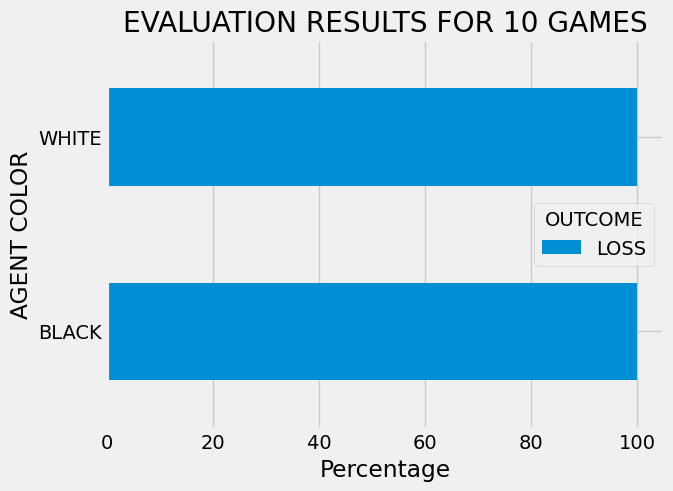

In [11]:
df = AGENT_EVALUATION(Stockfish_path, WHITE_PLAYER_POLICY, n_evaluations=5)

In [ ]:
df.head(5)

# Ready to Play Chess?

In [31]:
state = env.reset()

In [32]:
# The position of the black bishops in the beggining
state[:,:,2]

array([[0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [33]:
#inital black pawns
state[:,:,0]

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [34]:
# Initial positions
state[:,:,:12].sum(axis=2)

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]])

In [35]:
env.legal_actions

[494,
 501,
 129,
 136,
 1095,
 1022,
 949,
 876,
 803,
 730,
 657,
 584,
 1096,
 1023,
 950,
 877,
 804,
 731,
 658,
 585]

In [36]:
# decode which is the 730 action
env.decode(730)
# it is a pawn from c2 to c3

Move.from_uci('c2c3')

In [32]:
# Imagine we play that action
next_state, reward, done, info = env.step(730)

In [33]:
# Let´s Check if the pawn action was done
next_state[:,:,:12].sum(axis=2)

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
########################################## I ran until Agent_Evaluation and stopped. Now i will run this ###################

In [10]:
# Set the state_size
state_size = env.observation_space.shape

state_size

(8, 8, 119)

In [11]:
# Get the nº of actions
action_size = env.action_space.n

action_size

4672

### Preprocess the Game Screen

In [12]:
# Define the function to preprocess the state
def preprocess_state(state):
    # Convert the chess board state to a binary representation
    binary_state = np.zeros(64, dtype=np.float32)

    for i in range(64):
        piece = state.piece_at(i)
        if piece is not None:
            piece_value = {'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
                           'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6}
            binary_state[i] = piece_value[piece.symbol()]

    return binary_state

In [19]:
# Define the function to preprocess the state
def preprocess_state(state):
    # Convert the chess board state to a binary representation
    binary_state = np.zeros(64, dtype=np.float32)

    for i in range(64):
        piece = state[i]
        if piece != 0:
            piece_value = {'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
                           'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6}
            binary_state[i] = piece_value[piece]

    return binary_state

### Building the DQN

In [13]:
class DQN:
    def __init__(self, state_size, action_size):
        
        #define the state size
        self.state_size = state_size
        
        #define the action size
        self.action_size = action_size
        
        #define the replay buffer
        self.replay_buffer = deque(maxlen=5000)
        
        #define the discount factor
        self.gamma = 0.9  
        
        #define the epsilon value
        self.epsilon = 0.8   
        
        #define the update rate at which we want to update the target network
        self.update_rate = 1000    
        
        #define the main network
        self.main_network = self.build_network()
        
        #define the target network
        self.target_network = self.build_network()
        
        #copy the weights of the main network to the target network
        self.target_network.set_weights(self.main_network.get_weights())
        

    #Let's define a function called build_network which is essentially our DQN. 

    def build_network(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=4, padding='same', input_shape=self.state_size))
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (4, 4), strides=2, padding='same'))
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())


        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=Adam())

        return model

    #We learned that we train DQN by randomly sampling a minibatch of transitions from the
    #replay buffer. So, we define a function called store_transition which stores the transition information
    #into the replay buffer

    def store_transistion(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        

    #We learned that in DQN, to take care of exploration-exploitation trade off, we select action
    #using the epsilon-greedy policy. So, now we define the function called epsilon_greedy
    #for selecting action using the epsilon-greedy policy.
    
    def epsilon_greedy(self, state):
        if random.uniform(0,1) < self.epsilon:
            return np.random.randint(self.action_size)
        
        Q_values = self.main_network.predict(state)
        
        return np.argmax(Q_values[0])

    
    #train the network
    def train(self, batch_size):
        
        #sample a mini batch of transition from the replay buffer
        minibatch = random.sample(self.replay_buffer, batch_size)
        
        #compute the Q value using the target network
        for state, action, reward, next_state, done in minibatch:
            if not done:
                target_Q = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))
            else:
                target_Q = reward
                
            #compute the Q value using the main network 
            Q_values = self.main_network.predict(state)
            
            Q_values[0][action] = target_Q
            
            #train the main network
            self.main_network.fit(state, Q_values, epochs=1, verbose=0)
            
    #update the target network weights by copying from the main network
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())

### Training the network

In [14]:
num_episodes = 250
num_timesteps = 10000
batch_size = 4
num_screens = 2     


In [17]:
dqn = DQN(state_size, action_size)

In [20]:
done = False
time_step = 0

#for each episode
for i in range(num_episodes):
    
    #set return to 0
    Return = 0
    
    #preprocess the game screen
    state = preprocess_state(env.reset())

    #for each step in the episode
    for t in range(num_timesteps):
        
        #render the environment
        env.render()
        
        #update the time step
        time_step += 1
        
        #update the target network
        if time_step % dqn.update_rate == 0:
            dqn.update_target_network()
        
        #select the action
        action = dqn.epsilon_greedy(state)
        
        #perform the selected action
        next_state, reward, done, _ = env.step(action)
        
        #preprocess the next state
        next_state = preprocess_state(next_state)
        
        #store the transition information
        dqn.store_transistion(state, action, reward, next_state, done)
        
        #update current state to next state
        state = next_state
        
        #update the return
        Return += reward
        
        #if the episode is done then print the return
        if done:
            print('Episode: ',i, ',' 'Return', Return)
            break
            
        #if the number of transistions in the replay buffer is greater than batch size
        #then train the network
        if len(dqn.replay_buffer) > batch_size:
            dqn.train(batch_size)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [34]:
done = False
time_step = 0

# for each episode
for i in range(num_episodes):
    # set return to 0
    Return = 0

    # preprocess the game screen
    state = preprocess_state(env.reset())

    # for each step in the episode
    for t in range(num_timesteps):

        # update the time step
        time_step += 1

        # update the target network
        if time_step % dqn.update_rate == 0:
            dqn.update_target_network()

        # select the action
        action = dqn.epsilon_greedy(state)

        # perform the selected action
        next_state, reward, done, _ = env.step(action)

        # preprocess the next state
        next_state = preprocess_state(next_state)

        # store the transition information
        dqn.store_transistion(state, action, reward, next_state, done)

        # update current state to next state
        state = next_state

        # update the return
        Return += reward

        # if the episode is done then print the return
        if done:
            print('Episode:', i, ', Return:', Return)
            break

        # if the number of transitions in the replay buffer is greater than batch size
        # then train the network
        if len(dqn.replay_buffer) > batch_size:
            dqn.train(batch_size)

ValueError: Illegal move g1b1 for board position rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

In [32]:
def preprocess_state(state):
    binary_state = np.zeros((8, 8), dtype=np.float32)

    piece_mapping = {'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
                     'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6}

    for i in range(8):
        for j in range(8):
            piece = state[i, j]
            if np.any(piece != 0):
                binary_state[i, j] = piece_mapping.get(piece.item(0), 0)

    return binary_state


In [18]:
env.legal_actions

[494,
 501,
 129,
 136,
 1095,
 1022,
 949,
 876,
 803,
 730,
 657,
 584,
 1096,
 1023,
 950,
 877,
 804,
 731,
 658,
 585]

In [ ]:


>>> move = chess.Move.from_uci('e2e4')
>>> env.encode(move)
877
>>> env.encode(move) in env.legal_actions
True

>>> env.decode(877)
Move.from_uci('e2e4')

>>> import gym_chess
>>> from gym_chess.alphazero import BoardEncoding

>>> env = gym.make('Chess-v0')
>>> env = BoardEncoding(env, history_length=4)
>>> env = MyEsotericMoveEncoding(env)

In [ ]:
############################################## Q LEARNING

In [45]:
# Set the state_size
state_size = env.observation_space.shape

state_size

(8, 8, 119)

In [47]:
state_space_size =8*8*119

state_space_size

7616

In [51]:
# Get the nº of actions
action_size = env.action_space.n

action_size

4672

In [59]:
# Initialize Q-table
Q = np.zeros((state_space_size, action_space_size))

In [60]:
# Q-learning agent policies
def WHITE_PLAYER_POLICY(env, state, Q, epsilon):
    legal_actions = env.legal_actions
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice(legal_actions)
    else:
        action = np.argmax(Q[state][legal_actions])

    return action

def BLACK_PLAYER_POLICY(env, state, Q, epsilon):
    legal_actions = env.legal_actions
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice(legal_actions)
    else:
        action = np.argmax(Q[state][legal_actions])

    return action


In [61]:
import chess
import gym
import gym_chess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
import math

# Q-learning hyperparameters
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate


# Q-learning algorithm
def q_learning(env, Q, episodes):
    rewards = []
    
    for episode in tqdm(range(episodes)):
        state = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            if episode < (episodes / 2):
                action = WHITE_PLAYER_POLICY(env, state, Q, epsilon)
            else:
                action = BLACK_PLAYER_POLICY(env, state, Q, epsilon)
                
            next_state, reward, done, _ = env.step(action)
            
            # Q-learning update
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            
            state = next_state
            total_reward += reward
        
        rewards.append(total_reward)
    
    return rewards, Q

# Run Q-learning
episodes = 1000
rewards, Q = q_learning(env, Q, episodes)

# Plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Rewards')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: index 494 is out of bounds for axis 0 with size 8

In [23]:
action_size = 4672  # Number of possible actions

In [28]:
class DQN:
    def __init__(self, state_size, action_size):
        
        #define the state size
        self.state_size = (86, 86, 1)
        
        #define the action size
        self.action_size = action_size
        
        #define the replay buffer
        self.replay_buffer = deque(maxlen=1000)
        
        #define the discount factor
        self.gamma = 0.9
        
        #define the epsilon value
        self.epsilon = 0.99
        
        #define the update rate at which we want to update the target network
        self.update_rate = 5
        
        #define the main network
        self.main_network = self.build_network()
        
        #define the target network
        self.target_network = self.build_network()
        
        #copy the weights of the main network to the target network
        self.target_network.set_weights(self.main_network.get_weights())

        #learning rate
        self.learning_rate = .0001
        

    #Let's define a function called build_network which is essentially our DQN. 

    def build_network(self):
        model = Sequential()
        """
        model.add(Conv2D(8, (8, 8), strides=4, padding='same', input_shape=self.state_size))
        model.add(Activation('relu'))
        
        model.add(Conv2D(16, (4, 4), strides=2, padding='same'))
        model.add(Activation('relu'))
        
        model.add(Conv2D(16, (3, 3), strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())


        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        """
        
        model.add(Conv2D(filters=6, kernel_size=(7, 7), strides=3, activation='relu', input_shape=self.state_size))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=12, kernel_size=(4, 4), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(216, activation='relu'))
        model.add(Dense(self.action_size, activation=None))
        
        model.compile(loss='mse', optimizer=Adam(learning_rate=.0001, epsilon=1e-7))

        return model

    #We learned that we train DQN by randomly sampling a minibatch of transitions from the
    #replay buffer. So, we define a function called store_transition which stores the transition information
    #into the replay buffer

    def store_transistion(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        

    #We learned that in DQN, to take care of exploration-exploitation trade off, we select action
    #using the epsilon-greedy policy. So, now we define the function called epsilon_greedy
    #for selecting action using the epsilon-greedy policy.
    
    def epsilon_greedy(self, state):
        if random.uniform(0,1) < self.epsilon:
            random_discrete_action = np.random.choice(list(range(12)))
            
            return random_discrete_action
        
        Q_values = self.main_network.predict(state, verbose=0)
        
        discrete_action = np.argmax(Q_values[0])
        
        return discrete_action

    
    #train the network
    def train(self, batch_size):
        
        minibatch = np.array(random.sample(dqn.replay_buffer, batch_size), dtype=object)

        state_list = np.array(minibatch[:,0], dtype=object)
        state_list = np.hstack(state_list).reshape(batch_size, 86, 86, 1)

        next_state_list = np.array(minibatch[:,3])
        next_state_list = np.hstack(next_state_list).reshape(batch_size, 86, 86, 1)

        current_Q_values_list = dqn.main_network.predict(state_list, verbose=0)

        max_q = np.amax(dqn.target_network.predict(next_state_list, verbose=0), axis=1)

        for i, zip_ in enumerate(minibatch):

            state, action, reward, next_state, done = zip_

            if not done:
                target  = reward + dqn.gamma * max_q[i]
            else:
                target = reward

            updated_Q_value = target # (1 - self.learning_rate)*current_Q_values_list[i][action] + self.learning_rate*(target) # - current_Q_values_list[i][action]) # This is a different form of Q-learning (Min Q-Learning)

            current_Q_values_list[i][action] = updated_Q_value
        

        #train the main network
        self.main_network.fit(state_list, current_Q_values_list, epochs=1, verbose=0)
            
    #update the target network weights by copying from the main network
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())

### Training the network
Now, let's train the network. First, let's set the number of episodes we want to train the network:

In [55]:
num_episodes = 1000

# Define the batch size:
batch_size = 32

Instantiate the DQN class

In [56]:
dqn = DQN(state_size, action_size)

Start the training loop

In [65]:
for episode in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
    # Get the legal actions for the current state
        legal_moves = env.legal_moves

    # Convert legal_moves to a list of strings
        legal_actions = [str(move) for move in legal_moves]

    # Print the legal actions
        print("Legal Actions:", legal_actions)

    # Choose an action using epsilon-greedy strategy
        action = dqn.epsilon_greedy(state)

    # Check if the chosen action is in the list of legal actions
        if action not in legal_moves:
        # Handle the case when the chosen action is illegal
            print("Chosen action is illegal:", action)
            continue

    # Take action in the environment
        next_state, reward, done, _ = env.step(action)

    # Store the transition in the replay buffer
        dqn.store_transition(state, action, reward, next_state, done)

    # Update the Q-network
        dqn.update_network()

    # Update the target network
        dqn.update_target_network()

    # Update the current state
        state = next_state



Legal Actions: ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']
Chosen action is illegal: 8
Legal Actions: ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']
Chosen action is illegal: 10
Legal Actions: ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']
Chosen action is illegal: 6
Legal Actions: ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']
Chosen action is illegal: 0
Legal Actions: ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']
Chosen 

ValueError: in user code:

    File "C:\Users\David\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\David\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\David\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\David\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\David\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\David\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 86, 86, 1), found shape=(None, 8, 119)


Evaluate the trained DQN model:

In [ ]:
evaluation_results = AGENT_EVALUATION(Stockfish_path, dqn.epsilon_greedy, n_evaluations=100)

In [81]:
class ChessEnvironment:
    def __init__(self):
        self.board = chess.Board()

    def step(self, move):
        # Apply the move to the board
        self.board.push(move)

        # Get the next state after applying the move
        next_state = self.board.fen()

        # Determine the reward based on the current state
        reward = self.calculate_reward()

        # Check if the game is terminated
        done = self.board.is_game_over()

        return next_state, reward, done

    def calculate_reward(self):
        # Implement your reward calculation logic here
        # Return the reward value based on the current state
        pass


In [79]:
import chess
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Define the replay memory buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states)
        dones = np.array(dones, dtype=np.uint8)

        states = np.reshape(states, (batch_size, 8, 8, 12))
        next_states = np.reshape(next_states, (batch_size, 8, 8, 12))

        return states, actions, rewards, next_states, dones
    def __len__(self):
        return len(self.buffer)


# Define the Deep Q-Network
class DQN(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation="relu", padding="same")
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(64, activation="relu")
        self.fc2 = layers.Dense(num_actions)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# Define the Deep Q-Learning agent
class DQNAgent:
    def __init__(self, num_actions, replay_capacity=10000, batch_size=32, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.num_actions = num_actions
        self.replay_buffer = ReplayBuffer(replay_capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = DQN(num_actions)
        self.target_model = DQN(num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        q_values = self.model(np.expand_dims(state, axis=0))
        valid_moves = self.get_valid_moves(state)
        valid_q_values = tf.gather(q_values[0], valid_moves)
        return tf.argmax(valid_q_values).numpy()

    def get_valid_moves(self, state):
        chessboard = chess.Board(state)
        valid_moves = []
        for move in chessboard.legal_moves:
            valid_moves.append(self.move_to_index(move))
        return valid_moves

    def move_to_index(self, move):
        return move.from_square * 64 + move.to_square

    def index_to_move(self, index):
        from_square = index // 64
        to_square = index % 64
        return chess.Move(from_square, to_square)

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        next_states = np.reshape(next_states, (self.batch_size, 8, 8, 12))  # Reshape next_states

        next_q_values = self.target_model.predict(next_states)
        targets = rewards + (1 - dones) * self.gamma * np.amax(next_q_values, axis=1)

        mask = tf.one_hot(actions, self.num_actions)
        with tf.GradientTape() as tape:
            q_values = self.model(states)
            q_action_values = tf.reduce_sum(tf.multiply(q_values, mask), axis=1)
            loss = tf.reduce_mean(tf.square(targets - q_action_values))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)




In [82]:
# Initialize the DQNAgent and other variables
env = chess.Board()
num_actions = env.legal_moves.count()
agent = DQNAgent(num_actions)
episodes = 1000

# Main training loop
for episode in range(episodes):
    state = env.fen()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        valid_moves = agent.get_valid_moves(state)
        if action < len(valid_moves):
            move = agent.index_to_move(valid_moves[action])
            next_state, reward, done = env.step(move)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        if len(agent.replay_buffer) >= agent.batch_size:
            agent.train()
            agent.update_target_model()

    agent.train()
    agent.update_target_model()

    print("Episode:", episode, "Total Reward:", total_reward)

# Evaluate the agent's performance
evaluation_episodes = 100
total_wins = 0

for _ in range(evaluation_episodes):
    state = env.fen()
    done = False

    while not done:
        action = agent.select_action(state)
        valid_moves = agent.get_valid_moves(state)
        if action < len(valid_moves):
            move = agent.index_to_move(valid_moves[action])
            env.push(move)
            state = env.fen()
            done = env.is_game_over()

    if env.is_checkmate():
        total_wins += 1

win_rate = total_wins / evaluation_episodes
print("Win Rate:", win_rate)


AttributeError: 'Board' object has no attribute 'step'